# COMP9517 Group Project

### Model 4 : YOLOv8-NANO Segmentation

State-of-the-Art Benchmark

In order to train this state-of-the-art pretrained model as a benchmark for our turtles dataset, we will need to convert our dataset (currently in COCO format) into YOLO format. There are a lot of pre-existing methods which already cover this as YOLO is trained on the COCO dataset, so this is quite straightforward to process. As Ultralytics (the creators of YOLO) already have a tool that does this for us, we will use their tool for this model. Link to this tool can be found here https://github.com/ultralytics/JSON2YOLO

First we will migrate all the labels and images from the subfolders into a single folder. This code is based on Ultralytic's JSON2YOLO conversion which has been edited to load our updated_annotations.json and change to YOLO format.

Expected output : Run the following cell with the correct repository structure. That will then create a new folder with a file of all the new yolo annotations.

```
.
├── seaturtle-seg.YAML
└── yolo-dataset
    ├── seaturtle-seg.YAML
    └── labels
```

In [ ]:
####################################################################################
# MODIFIED FROM YOLO ULTRALYTICS REPOSITORY AND COPIED HERE FOR TUTOR'S CONVENIENCE!
# TLDR: This script will convert the COCO annotations to YOLO format and save them
# in the 'yolo-dataset' directory.
# 
# Please visit the original repository from Ultralytics for more information:
# https://github.com/ultralytics/JSON2YOLO
####################################################################################

import os
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from pathlib import Path
import numpy as np
import cv2

coco = COCO("./turtles-data/data/updated_annotations.json")
labels_dir = "./yolo-dataset/labels/"
Path(labels_dir).mkdir(
    parents=True, exist_ok=True
)

# Get category IDs and create a mapping for YOLO class IDs
category_ids = coco.getCatIds()
categories = coco.loadCats(category_ids)
category_mapping = {cat["id"]: idx for idx, cat in enumerate(categories)}

# Iterate over all images in the dataset
image_ids = coco.getImgIds()
for image_id in image_ids:
    # Load image information
    image_info = coco.loadImgs(image_id)[0]
    img_width, img_height = image_info["width"], image_info["height"]
    image_name = Path(image_info["file_name"]).stem

    # Get all annotations for the current image
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)

    # Initialize a list to hold YOLO-format data for this image
    yolo_annotations = []

    for ann in annotations:
        category_id = ann["category_id"]
        yolo_class_id = category_mapping[category_id]

        if "segmentation" in ann and ann["segmentation"]:
            if (
                isinstance(ann["segmentation"], dict)
                and "counts" in ann["segmentation"]
            ):
                # Handle unencoded RLE format by encoding it first
                rle = maskUtils.frPyObjects(ann["segmentation"], img_height, img_width)
                binary_mask = maskUtils.decode(rle)  # Decode the RLE to binary mask

                # Find contours from the binary mask
                contours, _ = cv2.findContours(
                    binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
                )

                for contour in contours:
                    if (
                        len(contour) >= 3
                    ):  # Ensure it has at least 3 points to form a polygon
                        yolo_format_points = []
                        for point in contour:
                            x, y = point[0]
                            x_normalized = x / img_width
                            y_normalized = y / img_height
                            yolo_format_points.extend([x_normalized, y_normalized])

                        # Add the class ID at the beginning of the line, followed by the points
                        yolo_annotations.append(
                            f"{yolo_class_id} " + " ".join(map(str, yolo_format_points))
                        )

        elif "bbox" in ann:
            # Fallback to bounding box if no segmentation (bbox format: [x_min, y_min, width, height])
            bbox = ann["bbox"]
            x_center = (bbox[0] + bbox[2] / 2) / img_width
            y_center = (bbox[1] + bbox[3] / 2) / img_height
            width = bbox[2] / img_width
            height = bbox[3] / img_height

            # Format as YOLO: [class_id, x_center, y_center, width, height]
            yolo_annotations.append(
                f"{yolo_class_id} {x_center} {y_center} {width} {height}"
            )

    # Write annotations into  a YOLO format file
    label_file_path = os.path.join(labels_dir, f"{image_name}.txt")
    with open(label_file_path, "w") as f:
        f.write("\n".join(yolo_annotations))

loading annotations into memory...
Done (t=1.48s)
creating index...
index created!


Next, run the following command to move all the images into the yolo-dataset folder as well under a subfolder called images.

In [4]:
# Run this to get all images from turtles-data and save them all in a single folder. Then we will partition
# the images into training and testing sets.

import os
import shutil
from tqdm import tqdm

# Source and destination directories
source_dir = "./turtles-data/data/images/"
destination_dir = "./yolo-dataset/images/"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

image_extensions = (".jpg", ".jpeg", ".png")
image_files = []

# Traverse through all directories and subdirectories in the source directory
for root, dirs, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(image_extensions):
            image_files.append(os.path.join(root, file))

# Progress bar for visualisation instead of a lot of prints
for source_file_path in tqdm(image_files, desc="Copying images . . .", unit="file"):
    destination_file_path = os.path.join(destination_dir, os.path.basename(source_file_path))
    shutil.copy2(source_file_path, destination_file_path)

Copying images . . .: 100%|██████████| 8709/8709 [00:00<00:00, 11128.08file/s]


Next, we will check and ensure the lengths of all images matches with labels (no missing labels or images)

In [5]:
# Check how many images are in folder
print(f"Number of images in folder: {len(os.listdir(destination_dir))}")

# Check how many labels are in the labels folder
print(f"Number of labels in folder: {len(os.listdir('./yolo-dataset/labels/'))}")

Number of images in folder: 8709
Number of labels in folder: 8709


After we have all of these images, our next step is to split them as per metadata-splits.csv. This is defined in our assignment specification and we must follow the split accordingly. We are required to have a train, validation, and testing split in accordance with open splits. Overall the file structure will look like this:

```
.
├── seaturtle-seg.YAML
├── images
│   ├── train
│   ├── test
│   └── valid
└── labels
│   ├── train
│   ├── test
│   └── valid
```

Expectation (from dataVisualisation.py)

```
----------------- Dataset Split -----------------

Training size: 5293
Validation size: 1117
Test size: 2299

----------------- DataLoaders -----------------

Training loader: 662 batches
Validation loader: 140 batches
Test loader: 288 batches
```

In [8]:
import os
import shutil
import pandas as pd

# Paths for images and labels
images_dir = "./yolo-dataset/images/"
labels_dir = "./yolo-dataset/labels/"

# Train/test/val
train_images_dir = "./yolo-dataset/images/train"
train_labels_dir = "./yolo-dataset/labels/train"
val_images_dir = "./yolo-dataset/images/valid"
val_labels_dir = "./yolo-dataset/labels/valid"
test_images_dir = "./yolo-dataset/images/test"
test_labels_dir = "./yolo-dataset/labels/test"

# Make files
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

# Load metadata to determine splits
metadata_path = "turtles-data/data/metadata_splits.csv"
metadata = pd.read_csv(metadata_path)


# Helper function to move files based on metadata
def move_files(file_list, src_images_dir, src_labels_dir, dest_images_dir, dest_labels_dir):
    for image_file in file_list:
        label_file = (
            os.path.splitext(image_file)[0] + ".txt"
        )  # Get corresponding label filename
        src_image_path = os.path.join(src_images_dir, image_file)
        src_label_path = os.path.join(src_labels_dir, label_file)

        # Move files if both image and label exist
        if os.path.exists(src_image_path) and os.path.exists(src_label_path):
            shutil.move(src_image_path, os.path.join(dest_images_dir, image_file))
            shutil.move(src_label_path, os.path.join(dest_labels_dir, label_file))
        # else:
            # print(f"[WARNING]: Missing image or label for {image_file}. Skipping.")


# Retrieve info and remove the t00x/x prefix
train_files = [os.path.basename(filename) for filename in metadata[metadata["split_open"] == "train"]["file_name"].tolist()]
val_files = [os.path.basename(filename) for filename in metadata[metadata["split_open"] == "valid"]["file_name"].tolist()]
test_files = [os.path.basename(filename) for filename in metadata[metadata["split_open"] == "test"]["file_name"].tolist()]

# Sanity check
# Print dataset sizes
print(f"----------------- Dataset Split -----------------\n")
print(f"Training size: {len(train_files)}")
print(f"Validation size: {len(val_files)}")
print(f"Test size: {len(test_files)}\n")

# Move files according to metadata split
move_files(train_files, images_dir, labels_dir, train_images_dir, train_labels_dir)
move_files(val_files, images_dir, labels_dir, val_images_dir, val_labels_dir)
move_files(test_files, images_dir, labels_dir, test_images_dir, test_labels_dir)

print(f"---------------- Finished Split ----------------\n")
print(f"[COMPLETE]: Dataset split into train, validation, and test sets based on metadata.\n")

# Sanity check round 2
print(f"Number of images in train folder: {len(os.listdir(train_images_dir))}")
print(f"Number of labels in train folder: {len(os.listdir(train_labels_dir))}")
print(f"Number of images in validation folder: {len(os.listdir(val_images_dir))}")
print(f"Number of labels in validation folder: {len(os.listdir(val_labels_dir))}")
print(f"Number of images in test folder: {len(os.listdir(test_images_dir))}")
print(f"Number of labels in test folder: {len(os.listdir(test_labels_dir))}")

----------------- Dataset Split -----------------

Training size: 5303
Validation size: 1118
Test size: 2308

---------------- Finished Split ----------------

[COMPLETE]: Dataset split into train, validation, and test sets based on metadata.

Number of images in train folder: 5293
Number of labels in train folder: 5293
Number of images in validation folder: 1117
Number of labels in validation folder: 1117
Number of images in test folder: 2299
Number of labels in test folder: 2299


In [9]:
# Check how many items are in folder
print(f"Number of images in folder: {len(os.listdir(destination_dir))}")

# Check how many items are in the labels folder
print(f"Number of labels in folder: {len(os.listdir('./yolo-dataset/labels/'))}")

Number of images in folder: 3
Number of labels in folder: 3


NOTE TO MARKER: Please go into yolo-dataset/seaturtle-seg.yaml and change the ABSOLUTE PATH, otherwise training will induce an error for you!

In [15]:
from ultralytics import YOLO
import torch

# Try to set gpu
# print(torch.cuda.is_available())
# torch.cuda.set_device(0)

# Load a model
model = YOLO("yolov8n-seg.pt")
print(model.device)

# Train the model
results = model.train(
    data="yolo-dataset/seaturtle-seg.yaml",  # NOTE TO MARKER: Please go into yolo-dataset/seaturtle-seg.yaml and change the ABSOLUTE PATH, otherwise training will induce an error for you!
    epochs=20,
    imgsz=512,
)

# Validate the model
metrics = model.val()  

New https://pypi.org/project/ultralytics/8.3.28 available 😃 Update with 'pip install -U ultralytics'


cpu


Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.1.0+cu118 CPU (12th Gen Intel Core(TM) i9-12900K)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=yolo-dataset/seaturtle-seg.yaml, epochs=20, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, opti

Predictions: 


image 1/1 d:\Dropbox\UNSW - MIT\COMP9517 - Computer Vision\Group Project\SeaTurtleID2022\yolo-dataset\predict_images\CAluWEgwPX.JPG: 352x512 1 turtle, 3 flippers, 1 head, 90.6ms
Speed: 4.4ms preprocess, 90.6ms inference, 4.0ms postprocess per image at shape (1, 3, 352, 512)


(-0.5, 1999.5, 1332.5, -0.5)

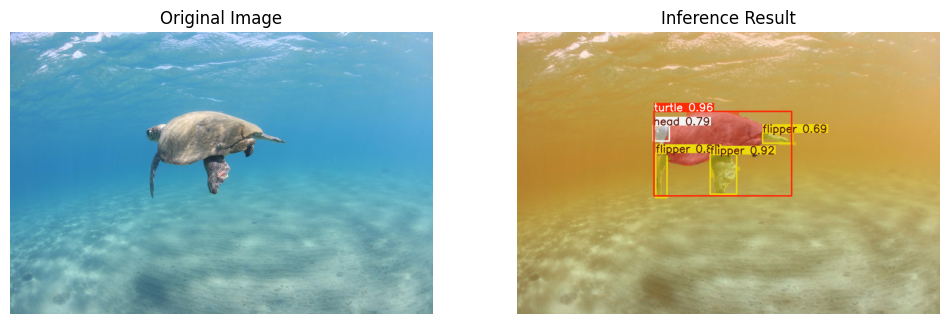

In [ ]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# img_path = "turtles-data/data/images/t001/anuJvqUqBB.JPG"
# model_path = "runs/segment/train2/weights/best.pt"
# model = YOLO(model_path)
# img = cv2.imread(img_path)
# results = model.predict(img_path)

# NOTE: To run, please change the model_path to the correct path of the best.pt file if needed.

model_path = "models/best_YOLO.pt"
model = YOLO(model_path)
results = model("yolo-dataset/predict_images/CAluWEgwPX.JPG")

original_image = cv2.imread("yolo-dataset/predict_images/CAluWEgwPX.JPG")
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Original
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# YOLO
axes[1].imshow(results[0].plot())
axes[1].set_title("Inference Result")
axes[1].axis("off")


image 1/1 d:\Dropbox\UNSW - MIT\COMP9517 - Computer Vision\Group Project\SeaTurtleID2022\yolo-dataset\predict_images\dLFculJDGP.JPG: 288x512 1 turtle, 4 flippers, 1 head, 75.0ms
Speed: 1.0ms preprocess, 75.0ms inference, 4.0ms postprocess per image at shape (1, 3, 288, 512)


(-0.5, 1999.5, 1123.5, -0.5)

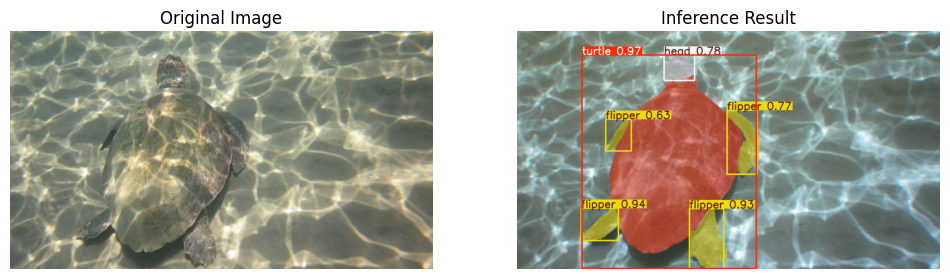

In [ ]:
# TODO: FOR TUTOR TO RUN, change the following picture path to the picture path you want to test.

picture_path = "yolo-dataset/predict_images/dLFculJDGP.JPG"

results = model(picture_path)
original_image = cv2.imread(picture_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Original
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# YOLO
axes[1].imshow(results[0].plot())
axes[1].set_title("Inference Result")
axes[1].axis("off")